In [40]:
%matplotlib inline
from pprint import pprint
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, QuantumRegister,transpile
from qiskit.visualization import array_to_latex
from qiskit_aer import AerSimulator
import numpy as np

[![Hanoi Tower](https://upload.wikimedia.org/wikipedia/commons/thumb/0/07/Tower_of_Hanoi.jpeg/450px-Tower_of_Hanoi.jpeg)](https://en.wikipedia.org/wiki/Tower_of_Hanoi)

[![Hanoi Tower steps](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8d/Iterative_algorithm_solving_a_6_disks_Tower_of_Hanoi.gif/330px-Iterative_algorithm_solving_a_6_disks_Tower_of_Hanoi.gif)](https://en.wikipedia.org/wiki/Tower_of_Hanoi)

| one   | two   | three |
|-------|-------|-------|
|$1\to3$|$1\to2$|$1\to2$| 
|       |$1\to3$|$1\to3$|
|       |$2\to3$|$2\to3$|
|       |       |$1\to3$|
|       |       |$3\to2$|
|       |       |$3\to1$|
|       |       |$2\to1$|
|       |       |$2\to3$|
|       |       |$1\to2$|
|       |       |$1\to3$|
|       |       |$2\to3$|

In [7]:
def hanoi(disc, start, aux, end, steps):
    if(disc == 0):
        return

    hanoi(disc-1, start, end, aux, steps)
    steps.append((disc,  start, end))
    hanoi(disc-1, aux, start, end, steps)
    return steps

In [17]:
steps = hanoi(2, 0, 1, 2, [])
pprint(steps, width=20)

[(1, 0, 1),
 (2, 0, 2),
 (1, 1, 2)]


In [29]:
steps_for_3 = hanoi(3, 0, 1, 2, [])
pprint(steps_for_3, width=20)

[(1, 0, 2),
 (2, 0, 1),
 (1, 2, 1),
 (3, 0, 2),
 (1, 1, 0),
 (2, 1, 2),
 (1, 0, 2)]


In [31]:
def hanoi_solver(towers, steps):
    for _, from_, to_ in steps:
        
        value = towers[from_].pop()
        towers[to_].append(value)
        print(towers)

towers = [list(range(3, 0, -1)), [], []]
hanoi_solver(towers, steps_for_3)
print('result: ', towers)

[[3, 2], [], [1]]
[[3], [2], [1]]
[[3], [2, 1], []]
[[], [2, 1], [3]]
[[1], [2], [3]]
[[1], [], [3, 2]]
[[], [], [3, 2, 1]]
result:  [[], [], [3, 2, 1]]


---

/home/alexandre/.asdf/installs/python/miniconda3-4.7.12/envs/quantum-oracles/lib/python3.8/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


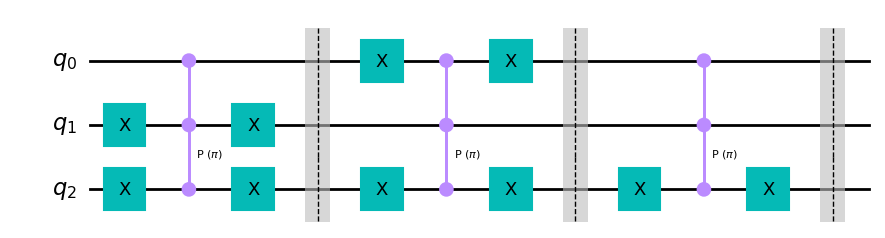

In [43]:
def generate_hanoi_u(total_discs=3, n_qubits=3):
    assert total_discs <= 2**n_qubits, "Invalid size"
    
    tower = QuantumCircuit(n_qubits, name="hanoi U")

    for i in range(1, total_discs+1):
        binary = f"{i:03b}"[::-1]
        zeros = [ i for i,v in enumerate(binary) if v=='0']
        tower.x(zeros)
        tower.mcp(np.pi, list(range(1, n_qubits)), 0)
        tower.x(zeros)
        tower.barrier()
    
    return tower

tower = generate_hanoi_u()
tower.draw('mpl')

In [44]:
def get_unitary(qc, sim=AerSimulator()):
    qc_copy = qc.copy()
    qc_copy.save_unitary()
    result = sim.run(transpile(qc_copy, sim), shots=1000).result().get_unitary()
    display(array_to_latex(result, max_size=10000))

get_unitary(tower)

<IPython.core.display.Latex object>

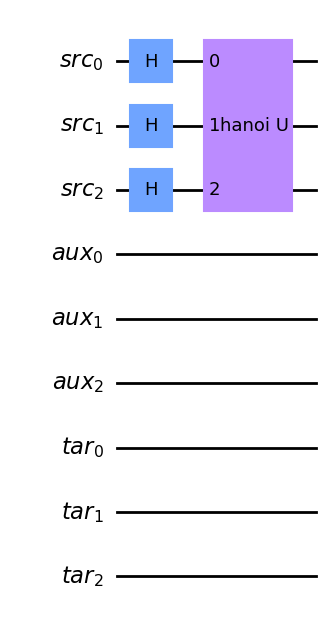

In [53]:
source = QuantumRegister(3, name="src")
aux = QuantumRegister(3, name="aux")
target = QuantumRegister(3, name="tar")

qc = QuantumCircuit(source, aux, target)

qc.h(source)
qc.append(tower, source)

qc.draw('mpl')

In [55]:
Statevector(qc).draw('latex')

<IPython.core.display.Latex object>